**Requirements**:
- You need to have the `cognite-sdk` package installed
- The environment variable `COGNITE_API_KEY` should be set

In [1]:
%matplotlib inline
import os

from cognite.client.experimental import CogniteClient
from cognite.model_hosting.data_spec import *
from cognite.model_hosting.data_fetcher import DataFetcher

client = CogniteClient()
mlh = client.model_hosting

# Introduction

In this tutorial we will deploy a scheduled function which adds together two time series and divides them by pi.

The source package for this function is located in the "transform" directory.

First we will create a "model" container for deploying our model versions to.

In [2]:
model_name = mlh.models.create_model(
    name="my-simple-function",
    input_fields=[{"name": "x1", "type": "TIME_SERIES"}, {"name": "x2", "type": "TIME_SERIES"}],
    output_fields=[{"name": "y", "type": "TIME_SERIES"}],
).name

Then we upload our source package to the hosting environment

In [3]:
source_package_id = mlh.source_packages.build_and_upload_source_package(
    name="my-simple-function", 
    runtime_version="0.1", 
    package_directory="transform"
).id

Then we deploy our function as a model version

In [4]:
version_name = mlh.versions.deploy_model_version(
    model_name=model_name,
    version_name="my-simple-function-v1",
    source_package_id=source_package_id,
).name

In [5]:
mlh.versions.get_model_version(model_name, version_name).status

'READY'

Now we can create a schedule spec to define which data we will pass to our function and how the input data will be processed.

In [6]:
# NOTE: USE YOUR OWN TIME SERIES HERE
INPUT_TS_1 = 6219610002944799  # Fill in your own time series ID
INPUT_TS_2 = 1014968819786991 # Fill in your own time series ID
OUTPUT_TS = 8895842852348905  # Fill in your own time series ID

schedule_data_spec = ScheduleDataSpec(
    input=ScheduleInputSpec(
        time_series={
            "x1": ScheduleInputTimeSeriesSpec(
                id=INPUT_TS_1, 
                aggregate="average", 
                granularity="10s"
            ),
            "x2": ScheduleInputTimeSeriesSpec(
                id=INPUT_TS_2, 
                aggregate="average", 
                granularity="10s")
        }
    ),
    output=ScheduleOutputSpec(
        time_series={
            "y": ScheduleOutputTimeSeriesSpec(
                id=OUTPUT_TS
            )
        }
    ),
    start="now",
    stride="1m",
    window_size="1m",
    slack="5m",
)



Then we can start the schedule

In [7]:
schedule_name = mlh.schedules.create_schedule(
    model_name=model_name,
    schedule_name="tutorial-schedule",
    schedule_data_spec=schedule_data_spec,
    description="Some description"
).name

Our output time series is now being updated every minute. Let's have a look!


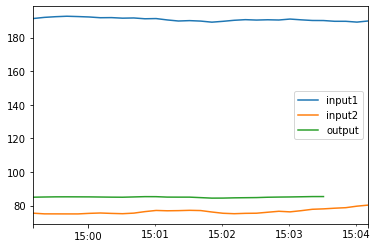

In [8]:
ds = DataSpec(
    time_series={
        "input1": TimeSeriesSpec(
            id=INPUT_TS_1, 
            aggregate="average", 
            granularity="10s", 
            start="5m-ago", 
            end="now"
        ),
        "input2": TimeSeriesSpec(
            id=INPUT_TS_2, 
            aggregate="average", 
            granularity="10s", 
            start="5m-ago", 
            end="now"
        ),
        "output": TimeSeriesSpec(
            id=OUTPUT_TS, 
            aggregate="average", 
            granularity="10s", 
            start="5m-ago", 
            end="now"
        )
})

df = DataFetcher(ds).time_series.fetch_dataframe(["input1", "input2", "output"])
df.plot()

Remember to clean up after yourself by deleting your model

In [9]:
mlh.models.delete_model(model_name)
mlh.source_packages.delete_source_package(source_package_id)